In [3]:
import pandas as pd

from collaborativeRecommender import cf_recommender_model, cf_global_metrics
from contentBasedRecommender import content_based_recommender_model, \
    cb_global_metrics
from init import interactions_test_indexed_df, \
    interactions_train_indexed_df, articles_df, \
    model_evaluator
from popularityRecommender import pop_global_metrics


# users: 1895
# users with at least 5 interactions: 1140
# of interactions: 72312
# of interactions from users with at least 5 interactions: 69868
# of unique user/news item interactions: 39106
# interactions on Train set: 31284
# interactions on Test set: 7822
********Collaborative Filtering Model********
Evaluating Collaborative Filtering (SVD Matrix Factorization) model...
Running evaluation for users
1139 users processed
********Content-Based Filtering Model*********
(1, 5000)
Evaluating Content-Based Filtering model...
Running evaluation for users
1139 users processed
********Popularity-Based Filtering Model********
Evaluating Popularity recommendation model...
Running evaluation for users
1139 users processed


In [23]:

class HybridRecommender():
    print("*******Hybrid Recommendation for the User********")
    MODEL_NAME = 'Hybrid'

    def __init__(self, cb_rec_model, cf_rec_model, items_df):
        self.cb_rec_model = cb_rec_model
        self.cf_rec_model = cf_rec_model
        self.items_df = items_df

    def get_model_name(self):
        return self.MODEL_NAME

    def recommend_items(self, user_id, items_to_ignore=[], topn=10, verbose=False):
        #Getting the top-1000 Content-based filtering recommendations
        cb_recs_df = self.cb_rec_model.recommend_items(user_id, items_to_ignore=items_to_ignore, verbose=verbose,
                                                           topn=1000).rename(columns={'recStrength': 'recStrengthCB'})
        #Getting the top-1000 Collaborative filtering recommendations
        cf_recs_df = self.cf_rec_model.recommend_items(user_id, items_to_ignore=items_to_ignore, verbose=verbose,
                                                           topn=1000).rename(columns={'recStrength': 'recStrengthCF'})
        #Combining the results by contentId
        recs_df = cb_recs_df.merge(cf_recs_df,
                                   how = 'inner',
                                   left_on = 'contentId',
                                   right_on = 'contentId')

        #Computing a hybrid recommendation score based on CF and CB scores
        recs_df['recStrengthHybrid'] = recs_df['recStrengthCB'] * recs_df['recStrengthCF']

        #Sorting recommendations by hybrid score
        recommendations_df = recs_df.sort_values('recStrengthHybrid', ascending=False).head(topn)

        if verbose:
            if self.items_df is None:
                raise Exception('"items_df" is required in verbose mode')

            recommendations_df = recommendations_df.merge(self.items_df, how = 'left',
                                                          left_on = 'contentId',
                                                          right_on = 'contentId')[['recStrengthHybrid', 'contentId', 'title', 'url', 'text', 'lang']]

        return recommendations_df
hybrid_recommender_model = HybridRecommender(content_based_recommender_model, cf_recommender_model, articles_df)


*******Hybrid Recommendation for the User********


In [24]:
print('Evaluating Hybrid model...')
hybrid_global_metrics, hybrid_detailed_results_df = model_evaluator.evaluate_model(hybrid_recommender_model)
#print('\nGlobal metrics:\n%s' % hybrid_global_metrics)
hybrid_detailed_results_df.head(10)


Evaluating Hybrid model...
Running evaluation for users
1139 users processed


,hits@5_count,hits@10_count,interacted_count,recall@5,recall@10,_person_id
76,27,40,192,0.140625,0.208333,3609194402293569455
17,38,56,134,0.283582,0.417910,-2626634673110551643
16,27,35,130,0.207692,0.269231,-1032019229384696495
10,37,52,117,0.316239,0.444444,-1443636648652872475
82,26,31,88,0.295455,0.352273,-2979881261169775358
161,20,28,80,0.250000,0.350000,-3596626804281480007
65,16,21,73,0.219178,0.287671,1116121227607581999
81,14,23,69,0.202899,0.333333,692689608292948411
106,14,19,69,0.202899,0.275362,-9016528795238256703
52,16,19,68,0.235294,0.279412,3636910968448833585


In [25]:
global_metrics_df = pd.DataFrame([pop_global_metrics, cf_global_metrics, cb_global_metrics, hybrid_global_metrics]) \
                        .set_index('modelName')
global_metrics_df

,recall@5,recall@10
modelName,,
Popularity,0.241882,0.372539
Collaborative Filtering,0.333930,0.468039
Content-Based,0.414600,0.524163
Hybrid,0.433904,0.537970


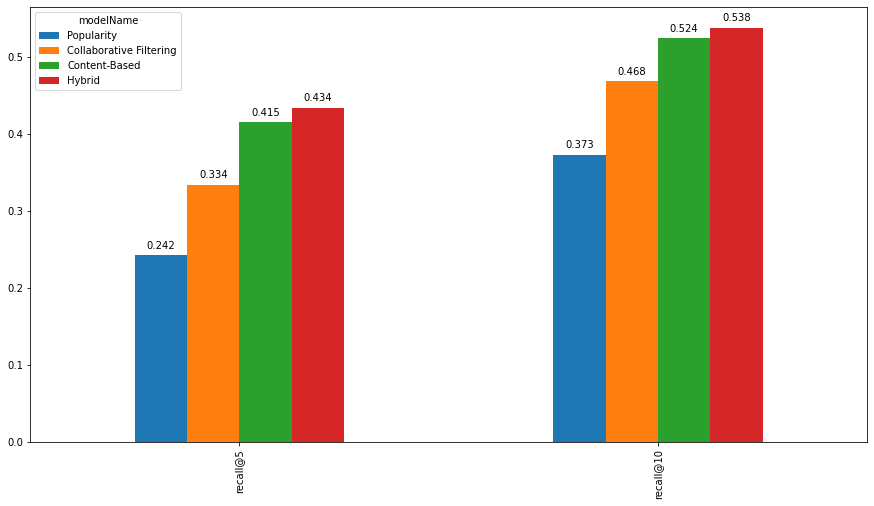

In [26]:
ax = global_metrics_df.transpose().plot(kind='bar', figsize=(15,8))
for p in ax.patches:
    ax.annotate("%.3f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points')


def inspect_interactions(person_id, test_set=True):
    if test_set:
        interactions_df = interactions_test_indexed_df
    else:
        interactions_df = interactions_train_indexed_df
    return interactions_df.loc[person_id].merge(articles_df, how = 'left',
                                                      left_on = 'contentId',
                                                      right_on = 'contentId').sort_values('eventStrength', ascending = False)[['eventStrength', 'contentId', 'title', 'url', 'lang']]




In [27]:
# print(inspect_interactions(-1479311724257856983, test_set=False).head(5))

hybrid_recommender_model.recommend_items(-2979881261169775358, topn=10, verbose=True)

,recStrengthHybrid,contentId,title,url,text,lang
0,0.901081,-5148591903395022444,Anti-If: The missing patterns,http://code.joejag.com/2016/anti-if-the-missin...,Around 10 years ago I encountered the anti-if ...,en
1,0.770242,-1453783314552286835,Progressive Web App - first introduced on Goog...,https://flights.airberlin.com/en-DE/progressiv...,airberlin is delighted to be the first airline...,en
2,0.735489,-2097075598039554565,"The Languages, Frameworks and Tools You Should...",http://tutorialzine.com/2016/12/the-languages-...,"The Languages, Frameworks and Tools You Should...",en
3,0.628726,-6728844082024523434,Seniority,http://merowing.info/2017/01/seniority/,People use different words to classify Enginee...,en
4,0.507511,-8954346068661072425,The technology behind preview photos,https://code.facebook.com/posts/99125254759357...,"First impressions matter, whether you're on a ...",en
5,0.504673,6062146090334604102,Serverless Data Sync in Web Apps with Bit Torrent,https://paul.kinlan.me/serverless-sync-in-web-...,Our team has built a lot of Progressive Web Ap...,en
6,0.495417,-4084394822880420062,Android Studio 2.2,http://android-developers.blogspot.com.br/2016...,"By Jamal Eason , Product Manager, Android Andr...",en
7,0.476376,-8992201526199201450,15 Awesome Sublime Text Plugins For Web Develo...,http://tutorialzine.com/2016/10/15-awesome-sub...,15 Awesome Sublime Text Plugins For Web Develo...,en
8,0.474983,-14569272361926584,Java 8 Streams - A Deeper Approach About Perfo...,http://guirmendes.blogspot.com.br/2017/02/java...,Introduction Java 8 was released almost three ...,en
9,0.460031,-5920475612630001479,How it feels to learn Javascript in 2016,https://hackernoon.com/how-it-feels-to-learn-j...,"Edit: Thanks for pointing typos and mistakes, ...",en
